In [5]:
from torch.nn import Module, ReLU, Conv2d, Linear, MaxPool2d, LogSoftmax, NLLLoss, Dropout, BatchNorm2d, LeakyReLU, GELU, SELU, Mish
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import flatten, float, no_grad
from torch.optim import Adam
import torch
import wandb
import math
import matplotlib.pyplot as plt
import numpy as np

In [36]:
PARAMETERS = {
    'data_augmentation': True,
    'batch_normalization': False,
    'filters': 64, # no. of filters in first layer
    'filter_org': 'half', # 'half', 'double'
    'dropout': 0,
    'activation': 'relu',
    'train_data_dir': "./data/train",
    'test_data_dir': "./data/val",
    'batch_size': 64,
    'learning_rate': 0.001,
    'epochs': 25,
    'dim': 256,
    'conv_kernel_size': 3,
    'dense_neurons': 1000
}

In [4]:
CLASSES = {
    0:'Amphibia',
    1:'Animalia',
    2:'Arachnida',
    3:'Aves',
    4:'Fungi',
    5:'Insecta',
    6:'Mammalia',
    7:'Mollusca',
    8:'Plantae',
    9:'Reptilia'
}

In [38]:
def get_data(param, type):
    if(type.lower() == 'train'):
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.RandomRotation(degrees=12),
            transforms.Resize((param['dim'],param['dim'])),
            transforms.ToTensor(), 
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])  
        ])

        tdataset = datasets.ImageFolder(root=param['train_data_dir'], transform=transform)
        total = len(tdataset)
        train_sample = math.ceil(total*(0.8))
        val_sample = total-train_sample
        # print(total, train_sample, val_sample)
        train_dataset, validation_dataset = torch.utils.data.random_split(tdataset, [train_sample, val_sample])
        train_dataloader = DataLoader(train_dataset, batch_size=param['batch_size'], shuffle=True)
        validation_dataloader = DataLoader(validation_dataset, batch_size=param['batch_size'], shuffle=False)
        return train_dataloader, validation_dataloader
    
    else:
        transform = transforms.Compose([
            transforms.Resize((param['dim'],param['dim'])),
            transforms.ToTensor(), 
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])  
        ])
        test_dataset = datasets.ImageFolder(root=param['test_data_dir'], transform=transform)
        test_dataloader = DataLoader(test_dataset, batch_size=param['batch_size'])
        return test_dataloader

    

In [38]:
# tr, val = get_data(PARAMETERS, 'train')
# for (img,label) in val:
#     print(label)

In [39]:
class CNN(Module):
    def __init__(self, param):
        super(CNN, self).__init__()
        self.param=param
        self.data_augmentation = param['data_augmentation']
        self.dropout = param['dropout']
        self.act = self.getActivation(param['activation'])
        self.filters = self.filter_logic(param['filters'], param['filter_org'])
        self.conv_ks = param['conv_kernel_size']
        self.dim = param['dim']
        self.bn = param['batch_normalization']
        self.dense_neurons = param['dense_neurons']


        curr_dim = self.dim
        self.conv1 = Conv2d(kernel_size=(self.conv_ks,self.conv_ks), in_channels=3, out_channels=self.filters[0])
        curr_dim -= (self.conv_ks-1)
        self.act1 = self.act
        if(self.bn): self.bn1 = BatchNorm2d(self.filters[0])
        self.pool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        curr_dim //= 2
        self.dropout1 = Dropout(p=self.dropout)

        self.conv2 = Conv2d(kernel_size=(self.conv_ks,self.conv_ks), in_channels=self.filters[0], out_channels=self.filters[1])
        curr_dim -= (self.conv_ks-1)
        self.act2 = self.act
        if(self.bn): self.bn2 = BatchNorm2d(self.filters[1])
        self.pool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        curr_dim //= 2
        self.dropout2 = Dropout(p=self.dropout)

        self.conv3 = Conv2d(kernel_size=(self.conv_ks,self.conv_ks), in_channels=self.filters[1], out_channels=self.filters[2])
        curr_dim -= (self.conv_ks-1)
        self.act3 = self.act
        if(self.bn): self.bn3 = BatchNorm2d(self.filters[2])
        self.pool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        curr_dim //= 2
        self.dropout3 = Dropout(p=self.dropout)

        self.conv4 = Conv2d(kernel_size=(self.conv_ks,self.conv_ks), in_channels=self.filters[2], out_channels=self.filters[3])
        curr_dim -= (self.conv_ks-1)
        self.act4 = self.act
        if(self.bn): self.bn4 = BatchNorm2d(self.filters[3])
        self.pool4 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        curr_dim //= 2
        self.dropout4 = Dropout(p=self.dropout)

        self.conv5 = Conv2d(kernel_size=(self.conv_ks,self.conv_ks), in_channels=self.filters[3], out_channels=self.filters[4])
        curr_dim -= (self.conv_ks-1)
        self.act5 = self.act
        if(self.bn): self.bn5 = BatchNorm2d(self.filters[4])
        self.pool5 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        curr_dim //= 2
        self.dropout5 = Dropout(p=self.dropout)

        ########## Comment out below line later ############    
        self.dense_neurons = curr_dim * curr_dim * self.filters[4]

        self.fc1 = Linear(in_features=(curr_dim * curr_dim * self.filters[4]), out_features=self.dense_neurons)  # How to calculate dimension of filters at previous level
        self.act6 = self.act
        self.dropout6 = Dropout(p=0.5)
        
        self.out = Linear(in_features=self.dense_neurons, out_features=10)
        self.act7 = LogSoftmax(dim=1)


    def getActivation(self, act):
        act = act.lower()
        if(act == 'relu'):
            return ReLU()
        elif(act == 'leakyrelu'):
            return LeakyReLU()
        elif(act == 'gelu'):
            return GELU()
        elif(act == 'selu'):
            return SELU()
        elif(act == 'mish'):
            return Mish()
    

    def filter_logic(self, filter, org):
        level = []
        org = org.lower()
        if org == 'same':
            level = [filter for i in range(5)]
        elif org == 'double':
            level = [filter*pow(2,i) for i in range(5)]
        elif org == 'half':
            level = [max(filter//pow(2,i),1) for i in range(5)]
        return level

    

    def forward(self, r):

        r=self.conv1(r)
        r=self.act1(r)
        if(self.bn): r=self.bn1(r)
        r=self.pool1(r)
        r=self.dropout1(r)

        r=self.conv2(r)
        r=self.act2(r)
        if(self.bn): r=self.bn2(r)
        r=self.pool2(r)
        r=self.dropout2(r)

        r=self.conv3(r)
        r=self.act3(r)
        if(self.bn): r=self.bn3(r)
        r=self.pool3(r)
        r=self.dropout3(r)

        r=self.conv4(r)
        r=self.act4(r)
        if(self.bn): r=self.bn4(r)
        r=self.pool4(r)
        r=self.dropout4(r)

        r=self.conv5(r)
        r=self.act5(r)
        if(self.bn): r=self.bn5(r)
        r=self.pool5(r)
        r=self.dropout5(r)

        r=flatten(r,1)
        r=self.fc1(r)
        r=self.act6(r)
        r=self.dropout6(r)
        
        r=self.out(r)
        output=self.act7(r)

        return output
        


In [40]:
# For personal debug use
def train(param):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = CNN(param).to(device)
    optimizer = Adam(model.parameters(), lr=param['learning_rate'])
    loss_function = NLLLoss()
    train_data_loader, validation_data_loader = get_data(param, 'train')
    

    for epo in range(param['epochs']):
        model.train()
        totalTrainLoss = 0
        totalValLoss = 0
        trainCorrect = 0
        valCorrect = 0
        train_counter=0
        validation_counter=0
        for (image, label) in train_data_loader:
            (image, label) = (image.to(device), label.to(device))
            prediction = model(image)
            loss = loss_function(prediction, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            totalTrainLoss += loss
            trainCorrect += (prediction.argmax(1) == label).type(float).sum().item()
            train_counter+=1
            # print(train_counter)
        
        with no_grad():
            model.eval()
            for (image, label) in validation_data_loader:
                (image, label) = (image.to(device), label.to(device))
                pred = model(image)
                totalValLoss += loss_function(pred, label)
                valCorrect += (pred.argmax(1) == label).type(float).sum().item()
                validation_counter+=1

        print(f"Epochs --> {epo}")
        print(f"Train Loss --> {(totalTrainLoss/train_counter).cpu().detach().numpy()}")
        print(f"Train Accuracy --> {trainCorrect/len(train_data_loader.dataset)}")
        print(f"Validation Loss --> {(totalValLoss/validation_counter).cpu().detach().numpy()}")
        print(f"Validation Accuracy --> {valCorrect/len(validation_data_loader.dataset)}")
        print("##########################################################################################")
    
    return model

In [41]:
# mdl = train(PARAMETERS)

Epochs --> 0
Train Loss --> 2.290273904800415
Train Accuracy --> 0.116625
Validation Loss --> 2.248206853866577
Validation Accuracy --> 0.15657828914457228
##########################################################################################
Epochs --> 1
Train Loss --> 2.2223458290100098
Train Accuracy --> 0.180375
Validation Loss --> 2.2107486724853516
Validation Accuracy --> 0.1615807903951976
##########################################################################################
Epochs --> 2
Train Loss --> 2.1504404544830322
Train Accuracy --> 0.219
Validation Loss --> 2.1068553924560547
Validation Accuracy --> 0.22761380690345173
##########################################################################################
Epochs --> 3
Train Loss --> 2.1085689067840576
Train Accuracy --> 0.23625
Validation Loss --> 2.0705678462982178
Validation Accuracy --> 0.24062031015507754
##########################################################################################
Epochs --> 

wandb: Network error (ConnectionError), entering retry loop.


Epochs --> 19
Train Loss --> 1.8783646821975708
Train Accuracy --> 0.335
Validation Loss --> 1.9304591417312622
Validation Accuracy --> 0.30665332666333167
##########################################################################################
Epochs --> 20
Train Loss --> 1.8707215785980225
Train Accuracy --> 0.33125
Validation Loss --> 1.9279935359954834
Validation Accuracy --> 0.3091545772886443
##########################################################################################
Epochs --> 21
Train Loss --> 1.862800121307373
Train Accuracy --> 0.338625
Validation Loss --> 1.8999676704406738
Validation Accuracy --> 0.3166583291645823
##########################################################################################
Epochs --> 22
Train Loss --> 1.84811270236969
Train Accuracy --> 0.33975
Validation Loss --> 1.900925636291504
Validation Accuracy --> 0.3266633316658329
##########################################################################################
Epochs --> 2

In [42]:
test_data_loader = get_data(PARAMETERS, 'test')
tstCorrect = 0
tstCounter = 0
y = []
y_pred = []
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
with no_grad():
    mdl.eval()
    for (image, label) in test_data_loader:
        (image, label) = (image.to(device), label.to(device))
        pred = mdl(image)
        y.extend(label.tolist())
        y_pred.extend(pred.argmax(1).tolist())
        # print(pred)
        tstCorrect += (pred.argmax(1) == label).type(float).sum().item()
        tstCounter+=PARAMETERS['batch_size']

print(tstCorrect)
print(tstCounter)
print((tstCorrect/tstCounter)*100)

664.0
2048
32.421875


## Plotting Confusion Matrix

In [62]:
def plot_confusion_mat(y, y_pred):
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sn
    mp = np.zeros((len(CLASSES),len(CLASSES)))
    for i,j in zip(y, y_pred):
        mp[i][j]+=1

    df_cm = pd.DataFrame(mp, [i for i in CLASSES.values()], [i for i in CLASSES.values()])
    plt.figure(figsize=(12,12))
    sn.set(font_scale=1) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}, cmap='crest', fmt='g') # font size
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

    # wandb.init(project="cs6910_assignment2")
    # wandb.run.name = f'Q1 Confusion Matrix'
    # wandb.log({"plot":wandb.Image(plt)})
# wandb.finish()

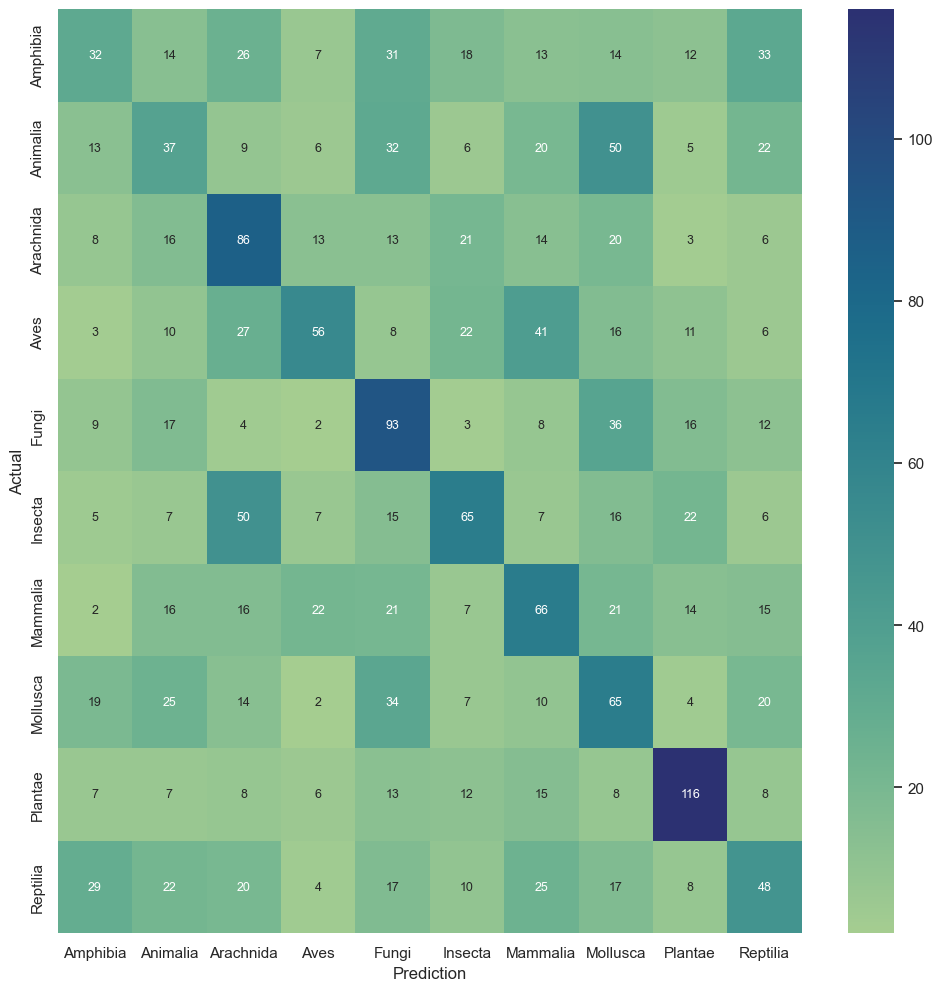

In [63]:
plot_confusion_mat(y,y_pred)

In [48]:
## for wandb sweeps
def train():
    wandb.init()
    param = wandb.config
    wandb.run.name = f'fltr_{param.filters}_fltrOrg_{param.filter_org}_dataAug_{param.data_augmentation}_batchNorm_{param.batch_normalization}_act_{param.activation}_batchSz_{param.batch_size}'

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = CNN(param).to(device)
    optimizer = Adam(model.parameters(), lr=param['learning_rate'])
    loss_function = NLLLoss()
    train_data_loader, validation_data_loader = get_data(param, 'train')
    

    for epo in range(param['epochs']):
        model.train()
        totalTrainLoss = 0
        totalValLoss = 0
        trainCorrect = 0
        valCorrect = 0
        train_counter=0
        validation_counter=0
        for (image, label) in train_data_loader:
            (image, label) = (image.to(device), label.to(device))
            prediction = model(image)
            loss = loss_function(prediction, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            totalTrainLoss += loss
            trainCorrect += (prediction.argmax(1) == label).type(float).sum().item()
            train_counter+=1
            print(train_counter)
        
        with no_grad():
            model.eval()
            for (image, label) in validation_data_loader:
                (image, label) = (image.to(device), label.to(device))
                pred = model(image)
                totalValLoss += loss_function(pred, label)
                valCorrect += (pred.argmax(1) == label).type(float).sum().item()
                validation_counter+=1

        tr_ls = (totalTrainLoss/train_counter).cpu().detach().numpy()
        tr_acc = trainCorrect/len(train_data_loader.dataset)
        val_ls = (totalValLoss/validation_counter).cpu().detach().numpy()
        val_acc = valCorrect/len(validation_data_loader.dataset)
        print(f"Epoch --> {epo}")
        print(f"Train Loss --> {tr_ls}")
        print(f"Train Accuracy --> {tr_acc}")
        print(f"Validation Loss --> {val_ls}")
        print(f"Validation Accuracy --> {val_acc}")
        
        lg={
            'epoch': epo+1,
            'tr_accuracy': tr_acc,
            'val_accuracy': val_acc,
            'tr_loss': tr_ls,
            'val_loss': val_ls
        }
        wandb.log(lg)

        # return model

In [49]:
sweep_config = {
  "method": "grid",  # Use grid search for this example
  "name": "Q1 Sweep",
  "metric": {"goal": "maximize", "name": "val_accuracy"},
  "parameters": {
    "data_augmentation":{"values": [True]},  # List of boolean values
    "batch_normalization":{"values": [False]},  # List of boolean values
    "filters":{"values": [64]},  # List of filter values for first layer
    "filter_org":{"values": ["half"]},  # List of filter organization options.. , "half", "double"
    "dropout":{"values": [0.2]},  # Dropout rates
    "activation":{"values": ["relu"]},  # Activation functions... , "tanh", "leaky_relu"
    "batch_size":{"values": [64]},
    "learning_rate":{"values": [0.001]},
    "epochs":{"values": [5]},
    "dim":{"values": [256]},
    "conv_kernel_size":{"values": [3]},
    "dense_neurons":{"values": [1000]},
    "train_data_dir":{"values": ["./data/train"]},
    "test_data_dir":{"values": ["./data/val"]}
  }
}


In [50]:
# wandb.init()
sweep_id = wandb.sweep(sweep_config, project="cs6910_assignment2")

Create sweep with ID: gqf3054y
Sweep URL: https://wandb.ai/cs23m070/cs6910_assignment2/sweeps/gqf3054y


In [ ]:
wandb.agent(sweep_id, function=train, count=1)
wandb.finish()

## Plotting Sample Images from Training Data

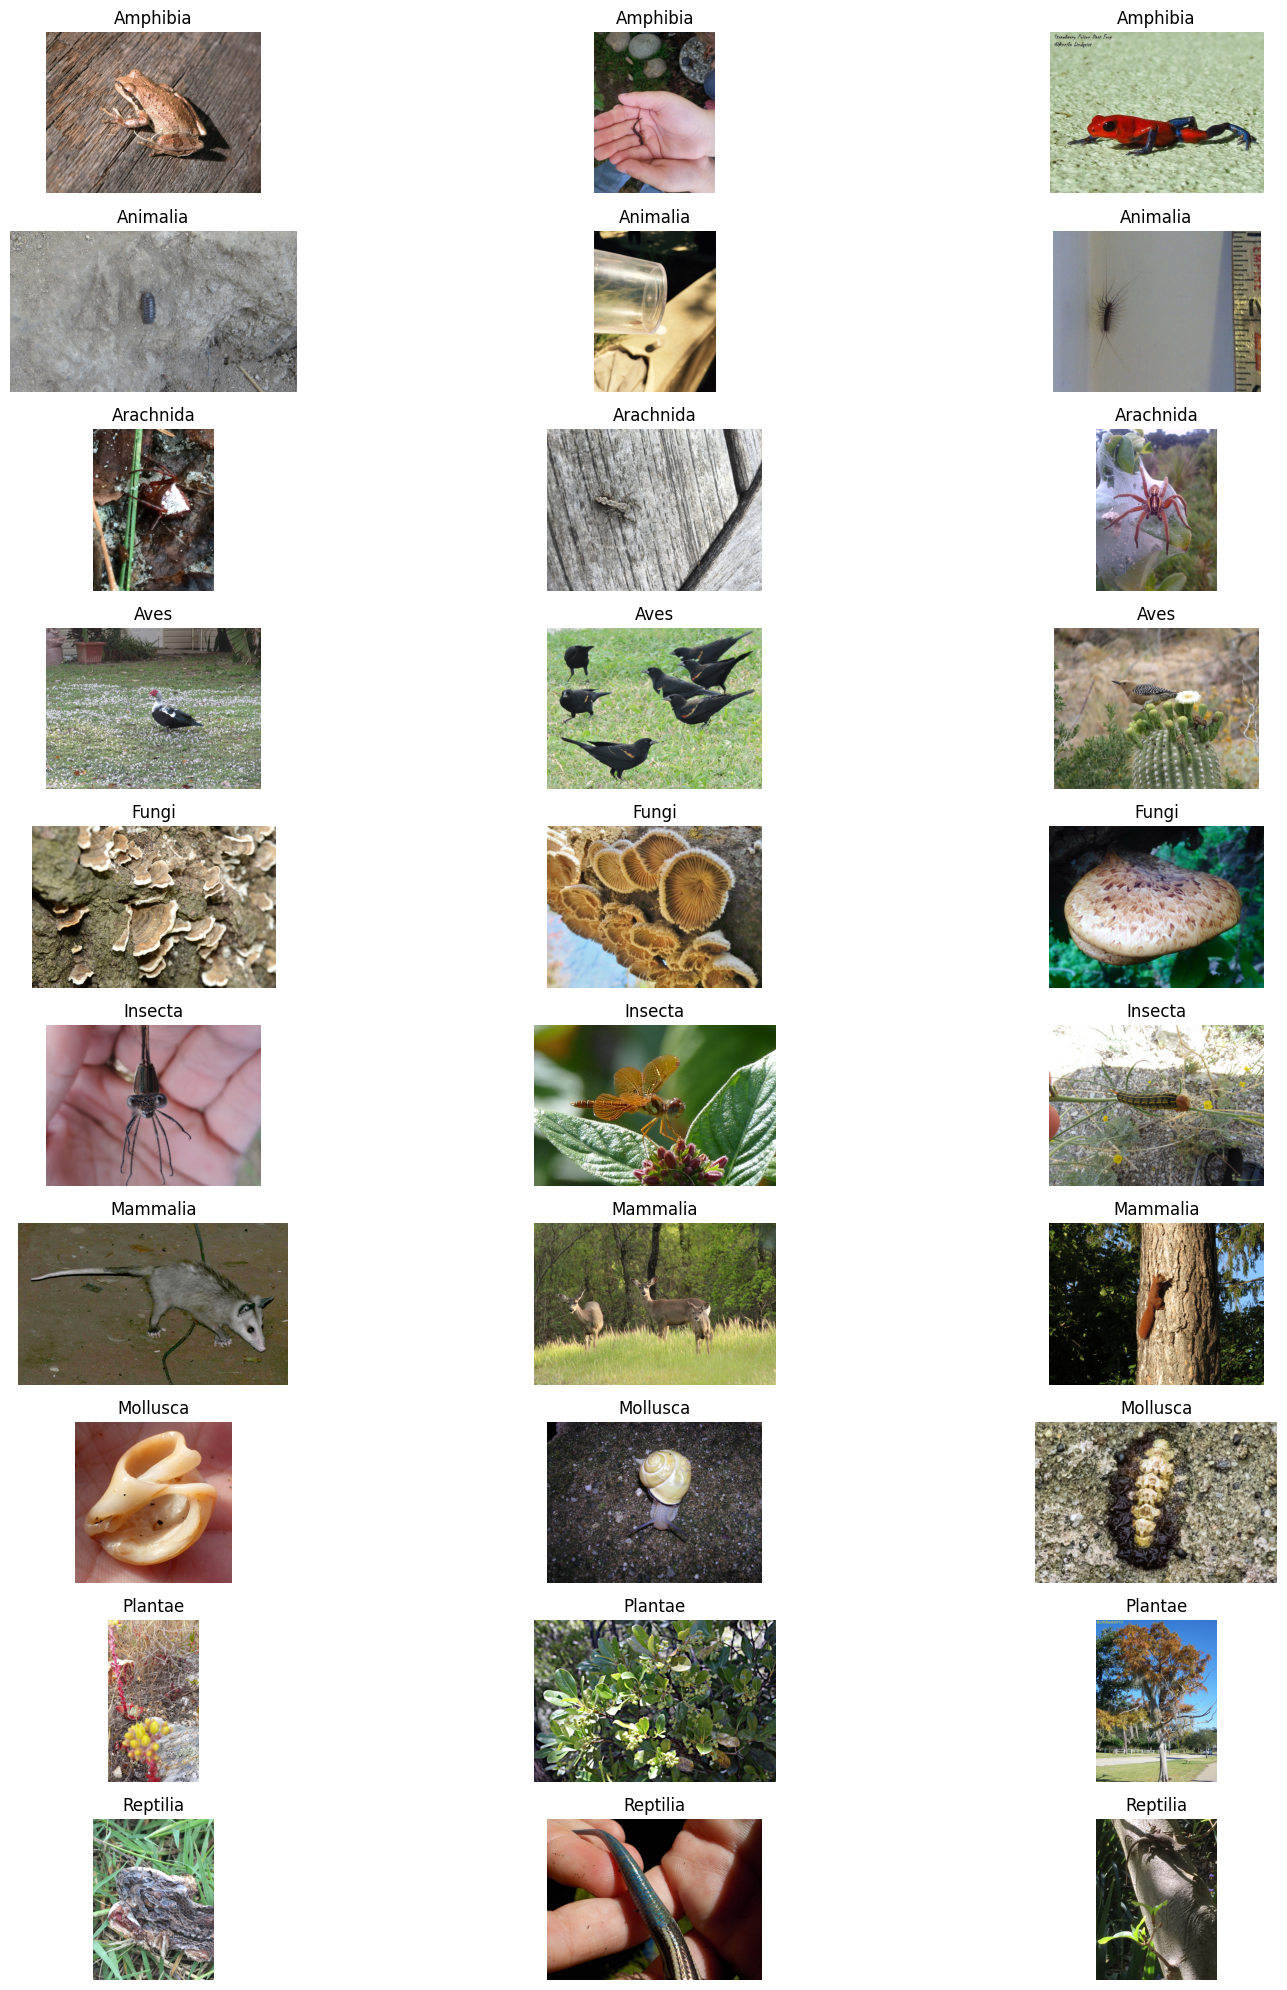

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [13]:
import os
import matplotlib.image as mpimg
import random

fig, axes = plt.subplots(10, 3, figsize=(17, 20))


for i in range(10):
    images = []
    folder_name = f"/Users/tirth/Documents/SEM2/DL/assignment/A2/data/train/{CLASSES[i]}/"
    for filename in os.listdir(folder_name):
        images.append(os.path.join(folder_name, filename))
    ind = [random.randint(0, len(images)) for _ in range(3)]
    for j in range(3):
        photo = mpimg.imread(images[ind[j]])
        axes[i, j].imshow(photo)
        axes[i, j].set_title(CLASSES[i])
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

wandb.init(project="cs6910_assignment2")
wandb.run.name = f'Q1 Sample Images'
wandb.log({"Sample Images ": wandb.Image(fig)})
wandb.finish()


In [17]:
# y = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
# y_pred = [9, 3, 1, 4, 0, 9, 2, 2, 1, 1, 0, 4, 3, 1, 2, 0, 7, 2, 5, 9, 1, 4, 0, 5, 1, 0, 9, 1, 0, 0, 5, 1, 9, 3, 0, 0, 2, 1, 1, 3, 9, 0, 2, 1, 9, 3, 9, 6, 4, 0, 0, 3, 0, 8, 5, 0, 3, 9, 1, 0, 8, 1, 1, 9, 2, 0, 0, 1, 1, 0, 1, 9, 2, 0, 7, 4, 9, 1, 1, 9, 6, 1, 6, 9, 1, 2, 7, 6, 1, 0, 8, 0, 9, 8, 9, 9, 9, 9, 6, 6, 7, 5, 1, 9, 2, 2, 3, 1, 9, 1, 8, 1, 1, 1, 9, 4, 2, 0, 1, 1, 9, 0, 2, 0, 9, 7, 0, 3, 9, 4, 3, 0, 8, 7, 1, 0, 1, 1, 2, 0, 9, 2, 0, 1, 8, 0, 1, 2, 9, 0, 9, 0, 9, 7, 6, 0, 1, 6, 7, 0, 2, 2, 0, 7, 2, 0, 8, 9, 0, 4, 6, 0, 7, 7, 5, 1, 5, 6, 1, 9, 6, 9, 9, 0, 4, 6, 3, 1, 9, 9, 1, 4, 0, 1, 7, 0, 0, 6, 0, 0, 7, 6, 3, 1, 1, 1, 1, 0, 1, 1, 4, 1, 0, 2, 7, 1, 1, 6, 0, 7, 9, 4, 7, 9, 1, 8, 9, 7, 1, 1, 6, 7, 9, 1, 1, 1, 1, 6, 9, 7, 1, 1, 1, 6, 1, 9, 7, 1, 1, 7, 6, 6, 9, 2, 0, 1, 9, 0, 2, 6, 4, 1, 6, 6, 9, 7, 7, 6, 9, 1, 1, 0, 1, 1, 9, 7, 1, 1, 9, 1, 9, 1, 1, 9, 1, 6, 9, 1, 1, 6, 1, 1, 1, 1, 9, 2, 1, 1, 9, 9, 1, 6, 2, 1, 1, 0, 1, 6, 1, 1, 9, 6, 3, 1, 1, 4, 1, 1, 1, 5, 9, 2, 7, 4, 1, 1, 7, 6, 9, 0, 1, 1, 9, 9, 1, 1, 6, 9, 6, 7, 7, 1, 0, 1, 6, 1, 7, 1, 1, 3, 1, 7, 9, 7, 9, 7, 1, 1, 6, 6, 6, 1, 9, 1, 4, 1, 1, 6, 1, 9, 9, 1, 9, 6, 9, 1, 0, 1, 3, 1, 6, 1, 1, 6, 1, 1, 7, 1, 1, 7, 0, 9, 9, 1, 7, 3, 2, 1, 1, 9, 2, 0, 3, 9, 2, 2, 7, 5, 7, 9, 1, 2, 0, 5, 2, 2, 8, 5, 1, 9, 0, 1, 3, 6, 2, 2, 2, 5, 1, 2, 3, 2, 9, 2, 9, 2, 1, 1, 8, 2, 2, 4, 1, 5, 5, 9, 2, 9, 2, 2, 2, 5, 1, 0, 6, 2, 3, 9, 2, 1, 2, 2, 3, 2, 2, 2, 9, 2, 5, 8, 5, 2, 7, 6, 2, 4, 8, 2, 2, 2, 1, 6, 1, 6, 3, 9, 9, 5, 3, 3, 6, 9, 2, 2, 3, 5, 0, 2, 2, 9, 3, 1, 6, 2, 2, 3, 2, 5, 6, 3, 2, 2, 5, 1, 8, 2, 6, 6, 3, 6, 5, 1, 3, 6, 2, 1, 2, 1, 5, 3, 3, 9, 9, 4, 3, 9, 2, 2, 1, 2, 2, 2, 2, 0, 7, 6, 6, 2, 6, 2, 1, 6, 3, 1, 1, 9, 8, 6, 1, 2, 1, 2, 0, 1, 2, 5, 6, 2, 2, 3, 6, 6, 3, 2, 2, 2, 5, 2, 8, 6, 1, 3, 2, 2, 0, 2, 8, 2, 1, 4, 9, 2, 2, 8, 0, 1, 9, 0, 0, 9, 3, 6, 6, 3, 9, 6, 3, 6, 7, 6, 3, 6, 6, 3, 6, 5, 9, 2, 3, 3, 4, 3, 3, 3, 1, 6, 3, 3, 6, 3, 3, 3, 6, 6, 3, 6, 6, 9, 6, 3, 3, 3, 3, 6, 2, 3, 6, 1, 6, 6, 3, 3, 3, 6, 9, 0, 9, 3, 4, 3, 3, 4, 3, 8, 0, 3, 6, 0, 3, 3, 6, 6, 3, 6, 6, 3, 9, 3, 6, 3, 0, 8, 3, 9, 5, 6, 1, 2, 8, 7, 3, 2, 5, 6, 7, 3, 6, 6, 9, 3, 6, 3, 6, 3, 9, 6, 9, 3, 3, 3, 6, 3, 6, 1, 5, 3, 5, 6, 6, 3, 9, 6, 3, 3, 3, 3, 8, 6, 6, 9, 3, 6, 6, 9, 3, 3, 8, 6, 1, 4, 3, 1, 5, 6, 5, 6, 3, 6, 6, 1, 9, 1, 3, 5, 8, 2, 8, 3, 6, 3, 4, 6, 3, 6, 1, 3, 8, 6, 3, 7, 2, 2, 3, 3, 5, 3, 0, 3, 9, 6, 6, 9, 0, 5, 3, 6, 3, 6, 2, 3, 3, 1, 2, 3, 7, 3, 2, 3, 6, 3, 1, 9, 4, 4, 1, 1, 4, 4, 1, 1, 7, 4, 6, 6, 0, 4, 4, 4, 9, 4, 6, 1, 7, 7, 1, 9, 7, 4, 1, 0, 4, 9, 4, 4, 4, 6, 8, 1, 6, 7, 9, 4, 4, 3, 4, 9, 6, 7, 1, 9, 1, 9, 1, 1, 1, 4, 0, 4, 6, 9, 1, 1, 1, 4, 0, 8, 3, 1, 7, 4, 0, 4, 9, 6, 9, 4, 1, 0, 4, 2, 4, 4, 1, 1, 4, 7, 9, 1, 1, 9, 8, 7, 5, 4, 4, 6, 8, 1, 4, 5, 7, 3, 0, 0, 4, 1, 4, 4, 9, 1, 1, 5, 2, 5, 0, 4, 6, 4, 7, 1, 8, 6, 1, 0, 7, 4, 4, 6, 4, 1, 4, 4, 9, 1, 3, 9, 9, 7, 5, 4, 4, 4, 4, 4, 4, 4, 9, 6, 7, 8, 7, 4, 4, 1, 9, 0, 0, 4, 7, 4, 4, 0, 4, 1, 4, 8, 6, 4, 4, 6, 4, 4, 4, 7, 4, 9, 9, 1, 4, 6, 1, 8, 1, 4, 1, 1, 4, 4, 6, 7, 4, 4, 7, 9, 7, 0, 4, 4, 4, 4, 1, 9, 5, 5, 1, 2, 2, 7, 1, 5, 2, 8, 1, 8, 5, 5, 6, 5, 5, 5, 5, 0, 7, 5, 2, 5, 5, 5, 1, 1, 3, 3, 5, 5, 3, 9, 2, 2, 5, 2, 5, 5, 5, 2, 6, 1, 5, 3, 7, 0, 3, 9, 2, 2, 5, 3, 5, 1, 1, 2, 1, 3, 1, 5, 8, 1, 3, 8, 0, 9, 2, 3, 4, 2, 1, 7, 5, 6, 6, 1, 3, 5, 5, 0, 2, 3, 6, 2, 5, 1, 5, 8, 8, 4, 1, 2, 3, 7, 8, 5, 5, 5, 1, 1, 5, 8, 2, 5, 6, 6, 5, 3, 1, 5, 6, 5, 9, 5, 7, 2, 2, 9, 8, 2, 2, 5, 5, 1, 8, 5, 6, 7, 6, 2, 5, 0, 1, 3, 3, 0, 8, 8, 7, 5, 3, 2, 2, 2, 7, 1, 5, 0, 4, 1, 2, 6, 7, 6, 0, 2, 5, 4, 3, 5, 5, 5, 2, 5, 2, 2, 2, 6, 5, 5, 1, 9, 8, 2, 5, 2, 2, 0, 5, 2, 8, 1, 1, 2, 5, 3, 5, 4, 3, 5, 5, 2, 2, 5, 5, 1, 6, 7, 9, 8, 6, 3, 6, 6, 6, 6, 1, 9, 6, 6, 6, 9, 3, 6, 6, 6, 6, 6, 6, 3, 6, 6, 9, 6, 2, 6, 8, 6, 9, 6, 3, 1, 6, 3, 6, 1, 6, 6, 9, 6, 6, 6, 6, 6, 6, 0, 1, 6, 6, 9, 8, 3, 6, 6, 6, 6, 0, 7, 1, 6, 6, 6, 7, 8, 6, 0, 6, 9, 6, 4, 5, 3, 6, 6, 7, 6, 6, 2, 0, 6, 1, 7, 9, 9, 4, 1, 2, 9, 3, 6, 9, 6, 9, 3, 6, 9, 1, 6, 4, 6, 6, 4, 1, 8, 6, 9, 9, 4, 1, 6, 6, 7, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 1, 1, 9, 6, 6, 6, 6, 6, 6, 7, 9, 9, 7, 3, 6, 6, 6, 9, 6, 6, 1, 6, 6, 6, 6, 6, 6, 9, 3, 0, 3, 7, 6, 6, 4, 2, 6, 9, 6, 6, 6, 6, 6, 7, 6, 8, 4, 3, 1, 8, 6, 3, 3, 6, 7, 6, 6, 9, 6, 3, 6, 6, 3, 6, 6, 6, 6, 2, 4, 6, 3, 6, 3, 6, 2, 2, 7, 8, 9, 1, 1, 4, 4, 6, 7, 0, 6, 0, 2, 6, 1, 7, 7, 2, 3, 1, 6, 6, 6, 7, 0, 7, 0, 8, 0, 0, 9, 9, 2, 2, 6, 9, 9, 7, 6, 1, 4, 9, 9, 7, 0, 7, 1, 4, 9, 4, 1, 1, 1, 7, 0, 9, 1, 1, 1, 9, 0, 7, 0, 7, 5, 7, 1, 9, 4, 4, 1, 0, 2, 9, 7, 1, 1, 7, 1, 4, 1, 7, 9, 7, 7, 7, 1, 7, 1, 7, 5, 0, 9, 4, 1, 1, 1, 7, 4, 1, 2, 1, 1, 6, 7, 1, 6, 2, 0, 4, 9, 7, 7, 0, 7, 9, 0, 6, 2, 1, 7, 3, 4, 2, 4, 9, 7, 4, 1, 1, 7, 2, 1, 3, 7, 4, 0, 0, 7, 2, 1, 9, 7, 9, 1, 1, 9, 7, 6, 2, 4, 1, 5, 1, 6, 0, 7, 1, 0, 4, 4, 1, 1, 1, 1, 9, 1, 1, 1, 9, 9, 2, 1, 1, 7, 9, 1, 7, 1, 0, 1, 4, 7, 2, 9, 7, 1, 1, 7, 7, 9, 1, 9, 0, 1, 1, 6, 1, 3, 8, 4, 6, 8, 8, 4, 8, 8, 6, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 8, 8, 8, 8, 4, 8, 8, 1, 8, 8, 8, 9, 8, 8, 2, 8, 1, 1, 5, 6, 1, 8, 4, 8, 8, 0, 8, 8, 8, 1, 6, 8, 8, 0, 8, 8, 1, 2, 7, 8, 8, 4, 6, 8, 7, 8, 6, 5, 8, 5, 8, 2, 4, 1, 8, 8, 8, 8, 5, 8, 8, 3, 2, 8, 3, 6, 6, 8, 8, 5, 8, 1, 7, 9, 1, 8, 2, 8, 8, 3, 8, 8, 6, 8, 8, 3, 8, 8, 9, 8, 2, 8, 2, 8, 8, 6, 6, 6, 5, 1, 8, 8, 5, 1, 8, 8, 8, 8, 1, 6, 5, 7, 9, 6, 8, 1, 1, 8, 8, 3, 8, 8, 0, 8, 1, 7, 9, 2, 8, 8, 8, 9, 9, 4, 8, 9, 2, 8, 8, 8, 0, 7, 4, 3, 8, 8, 8, 8, 9, 0, 8, 6, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 3, 4, 0, 8, 2, 8, 8, 6, 8, 8, 8, 3, 5, 6, 1, 3, 9, 6, 0, 1, 6, 7, 9, 9, 0, 9, 3, 3, 6, 1, 0, 9, 1, 6, 3, 9, 6, 1, 2, 6, 9, 8, 6, 9, 6, 6, 5, 0, 8, 9, 7, 6, 2, 9, 9, 9, 3, 9, 7, 6, 9, 6, 9, 9, 9, 6, 1, 1, 6, 9, 5, 3, 6, 3, 9, 9, 9, 6, 6, 9, 0, 1, 6, 9, 6, 1, 9, 1, 1, 1, 9, 4, 9, 0, 0, 9, 8, 9, 9, 9, 9, 6, 0, 9, 9, 1, 9, 1, 7, 1, 0, 1, 6, 9, 9, 0, 6, 6, 9, 4, 1, 6, 6, 4, 0, 9, 7, 2, 0, 9, 9, 3, 0, 9, 9, 8, 6, 4, 9, 9, 6, 9, 4, 5, 1, 9, 6, 0, 8, 2, 9, 1, 0, 6, 9, 7, 1, 9, 6, 1, 6, 3, 0, 9, 1, 5, 9, 9, 0, 0, 9, 9, 9, 3, 9, 6, 6, 1, 9, 1, 7, 0, 1, 2, 9, 0, 9, 0, 3, 1, 1, 1, 9, 1, 2, 1, 6, 9, 3, 9, 0, 1, 9, 5, 9, 1, 9, 1, 9, 9, 9, 9, 6]

# plot_confusion_mat(y,y_pred)